## **Classification models for the prediction of Cardiovascular Disease** 

Download [this kaggle dataset](https://www.kaggle.com/sulianova/cardiovascular-disease-dataset).


### Imports

In [ ]:
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn import tree
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.neural_network import MLPClassifier
from keras.models import Sequential
from keras.layers import Dense  
from keras import optimizers 
from sklearn.model_selection import train_test_split

### Dataset Description

In [ ]:
raw_data = pd.read_csv('/content/cardio_train.csv',delimiter=';')

In [ ]:
raw_data.shape

(70000, 13)

In [ ]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


In [ ]:
raw_data.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


### Data transformation

#### Data Cleaning

In [ ]:
raw_data.drop("id",axis=1,inplace=True)

In [ ]:
drop_total = raw_data.duplicated().sum()
raw_data.drop_duplicates(inplace=True)
print("Number of duplicate rows dropped: {}".format(drop_total))
print("New size of data frame: {}".format(raw_data.shape))

Number of duplicate rows dropped: 24
New size of data frame: (69976, 12)


In [ ]:
# Converting Age into years 
raw_data.loc[:, 'age'] = raw_data.loc[:, 'age'].apply(lambda x: int(x/365))

In [ ]:
#bmi = weight(kg)/height(cm)^2 * 10000

raw_data["bmi"] = round(raw_data["weight"] / (raw_data["height"]/100)**2)
df = raw_data.drop(['weight', 'height'], axis=1) 

In [ ]:
df.head()

,age,gender,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi
0,50,2,110,80,1,1,0,0,1,0,22.0
1,55,1,140,90,3,1,0,0,1,1,35.0
2,51,1,130,70,3,1,0,0,0,1,24.0
3,48,2,150,100,1,1,0,0,1,1,29.0
4,47,1,100,60,1,1,0,0,0,0,23.0


### Outlier Detection



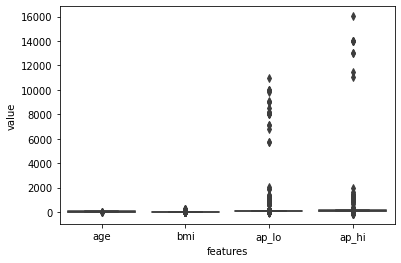

In [ ]:

melted_data = pd.melt(frame=df, id_vars="cardio", value_vars=['age','bmi','ap_lo','ap_hi'], var_name="features", value_name="value")
sns.boxplot(y='value',x='features',data = melted_data)

In [ ]:
lo_q1 = df['ap_lo'].quantile(0.25)
lo_q3 = df['ap_lo'].quantile(0.75)
hi_q1 = df['ap_hi'].quantile(0.25)
hi_q3 = df['ap_hi'].quantile(0.75)

lo_IQR = lo_q3 - lo_q1
hi_IQR = hi_q3 - hi_q1

lower_bound_lo= lo_q1 - 1.5*lo_IQR
lower_bound_hi = hi_q1 - 1.5*hi_IQR

lower_bound_lo,lower_bound_hi

(65.0, 90.0)

In [ ]:
lo_filter = ((df['ap_lo'] < 65) | (df['ap_hi'] < 90))  
hi_filter = ((df["ap_lo"] > 200) | (df["ap_hi"] > 250))
bmi_filter = ((df["bmi"] < 19) | (df['bmi'] > 54))

df = df[~lo_filter]
df = df[~hi_filter]
df = df[~bmi_filter]

print("Number of outliers removed:\nap_lo: {}\nap_hi: {}\nbmi: {}".format(sum(lo_filter),sum(hi_filter),sum(bmi_filter)))
print("Size of new data frame: {}".format(df.shape))

Number of outliers removed:
ap_lo: 3173
ap_hi: 993
bmi: 793
Size of new data frame: (65154, 11)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


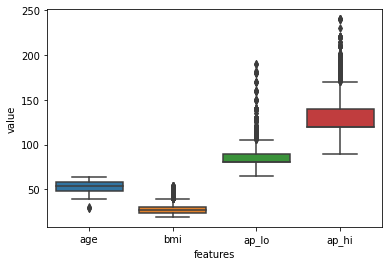

In [ ]:
melted_data = pd.melt(frame=df, id_vars="cardio", value_vars=['age','bmi','ap_lo','ap_hi'], var_name="features", value_name="value")
sns.boxplot(y='value',x='features',data = melted_data)

### Data Visualization

#### Numeric attributes

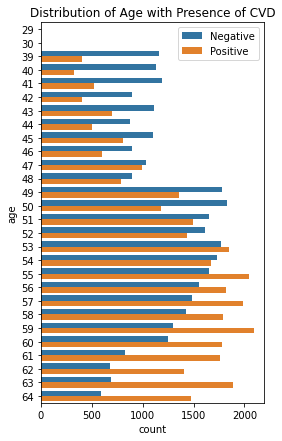

In [ ]:
fig, ax = plt.subplots(figsize = (4, 7))
sns.countplot(y= 'age', hue= 'cardio', data= df)
plt.title('Distribution of Age with Presence of CVD')
plt.legend(['Negative', 'Positive'],loc = 'upper right')
plt.show()

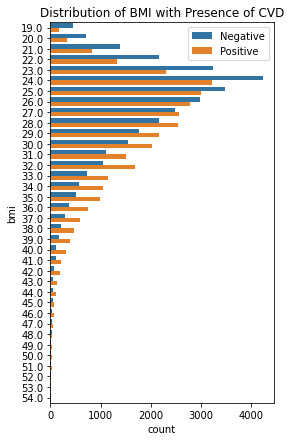

In [ ]:
fig, ax = plt.subplots(figsize = (4, 7))
sns.countplot(y= 'bmi', hue= 'cardio', data= df)
plt.title('Distribution of BMI with Presence of CVD')
plt.legend(['Negative', 'Positive'],loc = 'upper right')
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


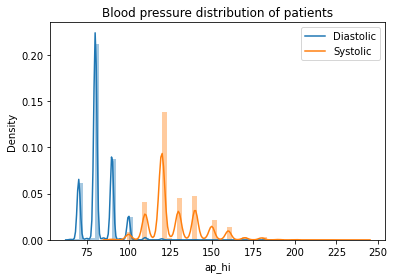

In [ ]:
sns.distplot(df['ap_lo'])
sns.distplot(df['ap_hi'])
plt.title('Blood pressure distribution of patients')
plt.legend(['Diastolic', 'Systolic'],loc = 'upper right')

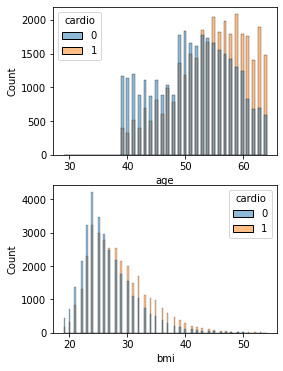

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(4, 6))
for variable, subplot in zip(df[['age','bmi']], ax.flatten()):
    sns.histplot(x = df[variable], hue=df['cardio'],ax=subplot)


#### Nominal attributes

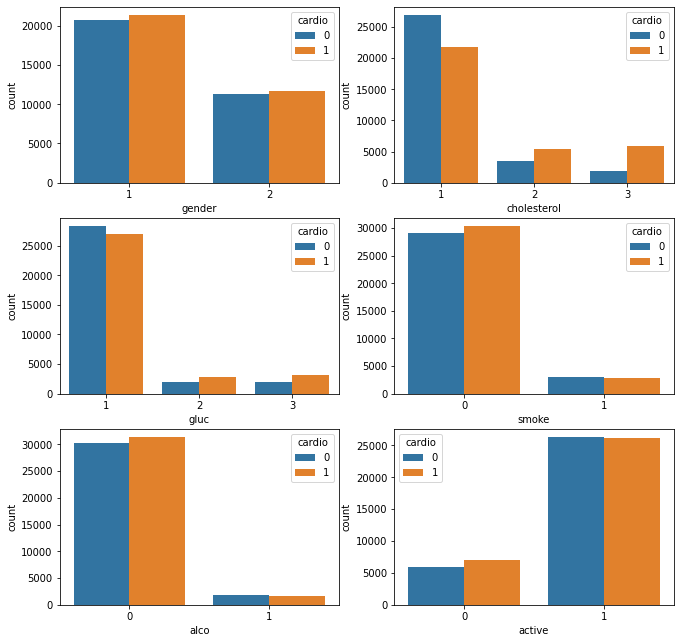

In [ ]:
fig, ax = plt.subplots(3, 2, figsize=(11, 11))
for variable, subplot in zip(df[['gender','cholesterol','gluc','smoke','alco','active']], ax.flatten()):
    sns.countplot(x = df[variable], hue=df['cardio'],ax=subplot)

#### Correlation matrix

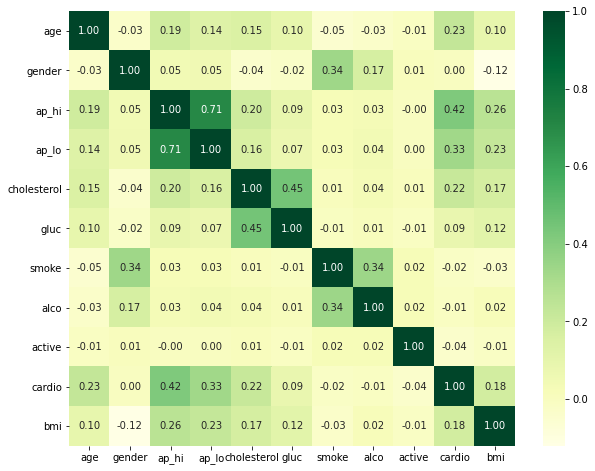

In [ ]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='YlGn', ax=ax)

### Models

#### Data preparation and function definitions

In [ ]:
Y = df['cardio']
X = df.drop(['cardio'],axis=1)
print(X.columns,'\n',X.shape,'\n')
print(Y.shape)

Index(['age', 'gender', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke',
       'alco', 'active', 'bmi'],
      dtype='object') 
 (65154, 10) 

(65154,)


In [ ]:
def conf_mat_scores(Y_true,Y_pred):
    tn, fp, fn, tp = (confusion_matrix(Y_true,Y_pred).ravel())
    acc = (tn+tp)/(tn+fp+fn+tp)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1 = 2*(recall * precision) / (recall + precision)
    return {
        'Accuracy': acc.round(4),
        'Precision':precision.round(4),
        'Recall':recall.round(4),
        'F1_score':f1.round(4),
        'True Negatives':tn,
        'False Positives':fp,
        'False Negatives':fn,
        'True Positives':tp}


In [ ]:
def pretty_table(scores,method_name="Enter Method Name"):
    return pd.DataFrame({method_name:pd.Series(scores)})


### Decision Trees

In [ ]:
dtc = tree.DecisionTreeClassifier(max_depth = 10)
dt_scores = conf_mat_scores(Y,cross_val_predict(dtc, X, Y, cv=10))
dt_results = pretty_table(dt_scores,method_name='Decision Tree')
dt_scores

{'Accuracy': 0.7253,
 'F1_score': 0.7214,
 'False Negatives': 9881,
 'False Positives': 8020,
 'Precision': 0.7429,
 'Recall': 0.7011,
 'True Negatives': 24078,
 'True Positives': 23175}

### Random Forest



In [ ]:
rfc= RandomForestClassifier(max_depth = 10)
rf_scores = conf_mat_scores(Y,cross_val_predict(rfc, X, Y, cv=10))
rf_results = pretty_table(rf_scores,method_name='Random Forest')
rf_scores

{'Accuracy': 0.7311,
 'F1_score': 0.7211,
 'False Negatives': 10407,
 'False Positives': 7110,
 'Precision': 0.7611,
 'Recall': 0.6852,
 'True Negatives': 24988,
 'True Positives': 22649}

### K nearest neighbours classifier

In [ ]:
knc = KNeighborsClassifier(n_neighbors=10)
knc_scores=conf_mat_scores(Y,cross_val_predict(knc,X,Y,n_jobs = -1,cv=10))
knc_results = pretty_table(knc_scores,method_name='K-Nearest Neighbours')
knc_scores

{'Accuracy': 0.7099,
 'F1_score': 0.6919,
 'False Negatives': 11838,
 'False Positives': 7062,
 'Precision': 0.7503,
 'Recall': 0.6419,
 'True Negatives': 25036,
 'True Positives': 21218}

### Logistic Regression

In [ ]:
lr = LogisticRegression()
lr_scores=conf_mat_scores(Y,cross_val_predict(lr,X,Y,n_jobs = -1,cv=10))
lr_results = pretty_table(lr_scores,method_name='Logistic Regression')
lr_scores

{'Accuracy': 0.7231,
 'F1_score': 0.7123,
 'False Negatives': 10728,
 'False Positives': 7313,
 'Precision': 0.7533,
 'Recall': 0.6755,
 'True Negatives': 24785,
 'True Positives': 22328}

### Gradient Boosting Classifier

In [ ]:
gbc = GradientBoostingClassifier()
gbc_scores=conf_mat_scores(Y,cross_val_predict(gbc,X,Y,n_jobs = -1,cv=10))
gbc_results = pretty_table(gbc_scores,method_name='Gradient Boosting')
gbc_scores

{'Accuracy': 0.7326,
 'F1_score': 0.7274,
 'False Negatives': 9817,
 'False Positives': 7602,
 'Precision': 0.7535,
 'Recall': 0.703,
 'True Negatives': 24496,
 'True Positives': 23239}

### Stochastic Gradient Descent

In [ ]:
sgd = SGDClassifier(loss='perceptron',penalty='l1',n_jobs = -1)
sgd_scores=conf_mat_scores(Y,cross_val_predict(sgd,X,Y,n_jobs = -1,cv=10))
sgd_results = pretty_table(sgd_scores,method_name='Stocastic Gradient Descent')
sgd_scores

{'Accuracy': 0.7017,
 'F1_score': 0.7023,
 'False Negatives': 10130,
 'False Positives': 9304,
 'Precision': 0.7113,
 'Recall': 0.6936,
 'True Negatives': 22794,
 'True Positives': 22926}

### Shallow Nueral Network using sklearn


In [ ]:
mlp = MLPClassifier(random_state=1, max_iter=300)
mlp_scores=conf_mat_scores(Y,cross_val_predict(mlp,X,Y,n_jobs = -1,cv=10))
mlp_results = pretty_table(mlp_scores,method_name='Shallow Nueral Net')
mlp_scores

{'Accuracy': 0.72,
 'F1_score': 0.7324,
 'False Negatives': 8088,
 'False Positives': 10157,
 'Precision': 0.7108,
 'Recall': 0.7553,
 'True Negatives': 21941,
 'True Positives': 24968}

### Deep Nueral Network using keras

In [ ]:
train, X_test, result, y_test = train_test_split(X, Y, test_size=0.33)
X_train, X_val, y_train, y_val = train_test_split(train, result, test_size=0.2)

In [ ]:
model = Sequential()

model.add(Dense(50, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(75, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(100, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(75, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(50, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                550       
_________________________________________________________________
dense_1 (Dense)              (None, 75)                3825      
_________________________________________________________________
dense_2 (Dense)              (None, 100)               7600      
_________________________________________________________________
dense_3 (Dense)              (None, 75)                7575      
_________________________________________________________________
dense_4 (Dense)              (None, 50)                3800      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 51        
Total params: 23,401
Trainable params: 23,401
Non-trainable params: 0
____________________________________________________

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val), batch_size=64)

Epoch 1/30
546/546 [==============================] - 1s 2ms/step - loss: 0.5632 - accuracy: 0.7225 - val_loss: 0.5541 - val_accuracy: 0.7316
Epoch 2/30
546/546 [==============================] - 1s 2ms/step - loss: 0.5624 - accuracy: 0.7199 - val_loss: 0.5545 - val_accuracy: 0.7250
Epoch 3/30
546/546 [==============================] - 1s 2ms/step - loss: 0.5637 - accuracy: 0.7192 - val_loss: 0.5607 - val_accuracy: 0.7312
Epoch 4/30
546/546 [==============================] - 1s 2ms/step - loss: 0.5613 - accuracy: 0.7203 - val_loss: 0.5798 - val_accuracy: 0.7122
Epoch 5/30
546/546 [==============================] - 1s 2ms/step - loss: 0.5596 - accuracy: 0.7220 - val_loss: 0.5743 - val_accuracy: 0.7146
Epoch 6/30
546/546 [==============================] - 1s 2ms/step - loss: 0.5632 - accuracy: 0.7201 - val_loss: 0.5510 - val_accuracy: 0.7297
Epoch 7/30
546/546 [==============================] - 1s 2ms/step - loss: 0.5604 - accuracy: 0.7229 - val_loss: 0.5484 - val_accuracy: 0.7311
Epoch 

In [ ]:
pred = (model.predict(X_test) > 0.5) * 1
dnn_scores = conf_mat_scores(y_test,pred)
dnn_results = pretty_table(dnn_scores,method_name="Deep Nueral Net")
dnn_scores

{'Accuracy': 0.7277,
 'F1_score': 0.736,
 'False Negatives': 2780,
 'False Positives': 3075,
 'Precision': 0.7264,
 'Recall': 0.7459,
 'True Negatives': 7484,
 'True Positives': 8162}

### Comparisions

In [ ]:
comparision = pd.concat([dt_results,rf_results,knc_results,lr_results,gbc_results,sgd_results, mlp_results,dnn_results], axis=1)

In [ ]:
comparision

,Decision Tree,Random Forest,K-Nearest Neighbours,Logistic Regression,Gradient Boosting,Stocastic Gradient Descent,Shallow Nueral Net,Deep Nueral Net
Accuracy,0.7253,0.7311,0.7099,0.7231,0.7326,0.7017,0.7200,0.7277
Precision,0.7429,0.7611,0.7503,0.7533,0.7535,0.7113,0.7108,0.7264
Recall,0.7011,0.6852,0.6419,0.6755,0.7030,0.6936,0.7553,0.7459
F1_score,0.7214,0.7211,0.6919,0.7123,0.7274,0.7023,0.7324,0.7360
True Negatives,24078.0000,24988.0000,25036.0000,24785.0000,24496.0000,22794.0000,21941.0000,7484.0000
False Positives,8020.0000,7110.0000,7062.0000,7313.0000,7602.0000,9304.0000,10157.0000,3075.0000
False Negatives,9881.0000,10407.0000,11838.0000,10728.0000,9817.0000,10130.0000,8088.0000,2780.0000
True Positives,23175.0000,22649.0000,21218.0000,22328.0000,23239.0000,22926.0000,24968.0000,8162.0000


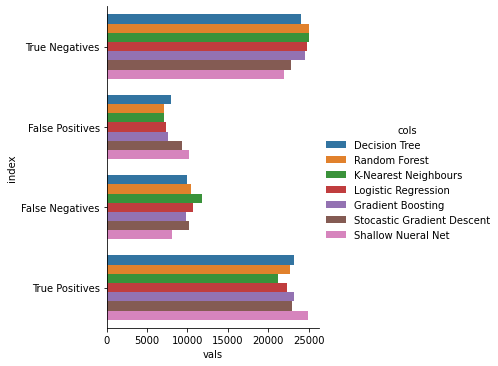

In [ ]:
matrix_scores = comparision.drop('Deep Nueral Net', 1)
matrix_scores = matrix_scores.drop(comparision.index[[0,1,2,3]]) 
matrix_scores = matrix_scores.reset_index().melt('index', var_name='cols',  value_name='vals')
g = sns.catplot(y="index", x="vals", hue='cols', data=matrix_scores, kind='bar')

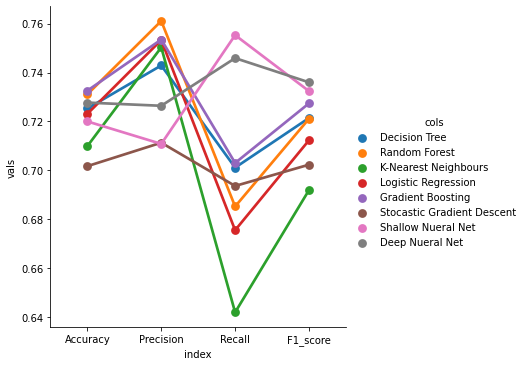

In [ ]:
matrix_scores = comparision.drop(comparision.index[[4,5,6,7]]) 
matrix_scores = matrix_scores.reset_index().melt('index', var_name='cols',  value_name='vals')
g = sns.catplot(x="index", y="vals", hue='cols', data=matrix_scores, kind='point')